In [1]:
# Set up session
import ee
ee.Initialize()

Open some dataset in Hispaniola


In [2]:
zoomed_out =  ee.Geometry.Polygon(
        [[[-74.60668900677238, 20.088333497505946],
          [-74.60668900677238, 17.687361057873034],
          [-68.11376908489738, 17.687361057873034],
          [-68.11376908489738, 20.088333497505946]]])
zoomed_in =  ee.Geometry.Polygon(
        [[[-71.7976970344606, 19.335441167371748],
          [-71.7976970344606, 19.19316176101097],
          [-71.60268971024185, 19.19316176101097],
          [-71.60268971024185, 19.335441167371748]]])

collection = ee.ImageCollection('MODIS/006/MOD44B').filterDate('2000-01-01', '2019-12-31').sort('system:time_start', False)#.filterBounds(zoomed_out).filterDate('2000-01-01', '2019-12-31').sort('system:time_start', False)
veg2019 = collection.filterDate('2019-01-01', '2019-12-31').first()
veg2018 = collection.filterDate('2018-01-01', '2018-12-31').first()
veg2000 = collection.filterDate('2000-01-01', '2000-12-31').first()

Put all of these on a map (reference)


In [3]:
import folium
import geehydro

In [4]:
# Use folium to visualize the imagery.
map = folium.Map(location = [18.999768, -71.374124], zoom_start=8)
map.addLayer(veg2000, {'gain':2},'2000')
map.addLayer(veg2019, {'gain':2}, '2019')
map.addLayer(veg2018, {'gain':2},'2018')
folium.LayerControl().add_to(map)
map

Plot cumulative differences in vegetation(ignore this bit because I abandoned the idea)




In [5]:
collectionNonVeg = collection.filterDate('2000-01-01', '2019-12-31').sort('system:time_start', False).select('Percent_NonVegetated')

Check that collection still contains data (ignore this bit because I abandoned the idea)



In [6]:
map = folium.Map(location = [18.999768, -71.374124], zoom_start=8)
map.addLayer(collectionNonVeg.first(), {'gain':2},'nonVeg')
folium.LayerControl().add_to(map)
map

In [7]:
mean = collectionNonVeg.mean()

def subtracting(image):
  return image.subtract(mean).set('system:time_start', image.get('system:time_start'))

series = collectionNonVeg.map(subtracting)
series_sum = series.sum()

map = folium.Map(location = [18.999768, -71.374124], zoom_start=8)
map.addLayer(series_sum, {'gain':2},'Cumulative difference in non-vegetation')
folium.LayerControl().add_to(map)
map

TIME SERIES (and it works!)

In [23]:
%matplotlib inline
from IPython.display import Image
import ee, datetime
import pandas as pd
from pylab import *
from matplotlib.pylab import rcParams


# List of used image bands
band_list = ['Percent_Tree_Cover', 'Percent_NonTree_Vegetation', 'Percent_NonVegetated']
point = ee.Geometry.Point(19.151827, -71.528765)

collection = ee.ImageCollection('MODIS/006/MOD44B').select(band_list)#.filterBounds(point)#.filterBounds(zoomed_out).filterDate('2000-01-01', '2019-12-31').sort('system:time_start', False)

count = collection.size()
print('Number of images in collection: ', str(count.getInfo())+'\n')

# Get info from the point

info = collection.getRegion(geometry=zoomed_out, scale=20000).getInfo()    #.filterBounds(zoomed_out).getInfo() # change colelction by series


print(info)

# Reshape image collection 
# Spearate header from data, and store data in an array
header = info[0]
data = array(info[1:])

# Extract time from data
iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(np.float)
#print(yData)

# Reshape EVI array into Pandas Dataframe
df = pd.DataFrame(data=yData, columns=band_list)

df['time'] = pd.Series(time, index=df.index)

# get mean value for every year
group =df.groupby(['time']).mean()


#print(df['time'])
print(group['Percent_Tree_Cover'])

Number of images in collection:  20

[['id', 'longitude', 'latitude', 'time', 'Percent_Tree_Cover', 'Percent_NonTree_Vegetation', 'Percent_NonVegetated'], ['2000_03_05', -74.47033705350833, 17.696811097154573, 952214400000, None, None, None], ['2001_03_06', -74.47033705350833, 17.696811097154573, 983836800000, None, None, None], ['2002_03_06', -74.47033705350833, 17.696811097154573, 1015372800000, None, None, None], ['2003_03_06', -74.47033705350833, 17.696811097154573, 1046908800000, None, None, None], ['2004_03_05', -74.47033705350833, 17.696811097154573, 1078444800000, None, None, None], ['2005_03_06', -74.47033705350833, 17.696811097154573, 1110067200000, None, None, None], ['2006_03_06', -74.47033705350833, 17.696811097154573, 1141603200000, None, None, None], ['2007_03_06', -74.47033705350833, 17.696811097154573, 1173139200000, None, None, None], ['2008_03_05', -74.47033705350833, 17.696811097154573, 1204675200000, None, None, None], ['2009_03_06', -74.47033705350833, 17.69681109

<AxesSubplot:xlabel='time'>

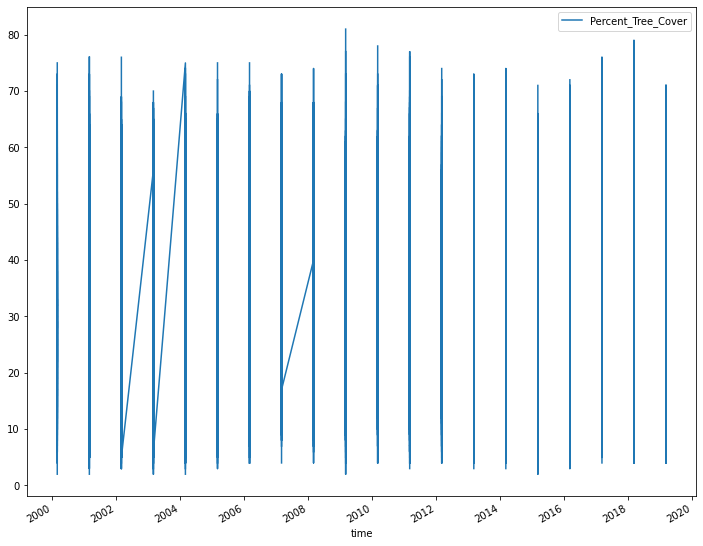

In [63]:
df.plot(x='time', y='Percent_Tree_Cover', figsize=(12,10))

<AxesSubplot:xlabel='time'>

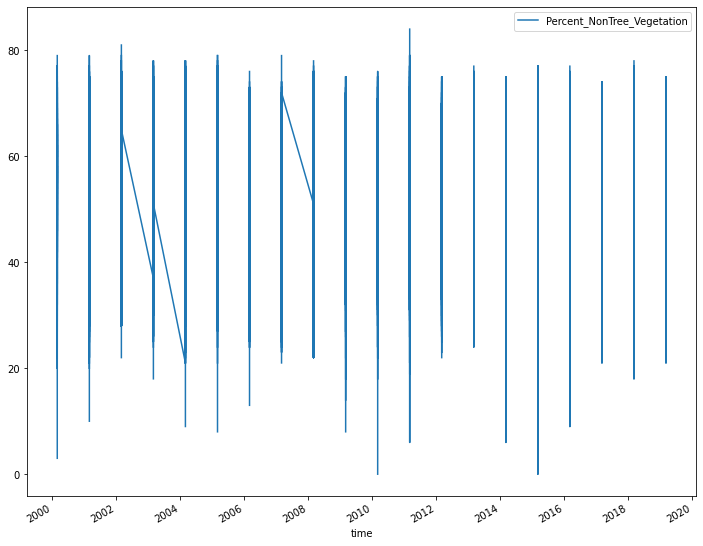

In [60]:
df.plot(x='time', y='Percent_NonTree_Vegetation', figsize=(12,10))

<AxesSubplot:xlabel='time'>

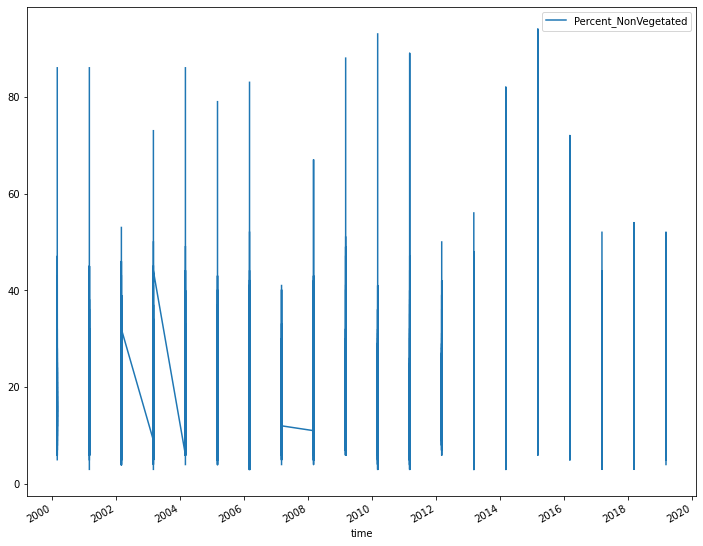

In [61]:
df.plot(x='time', y='Percent_NonVegetated', figsize=(12,10))

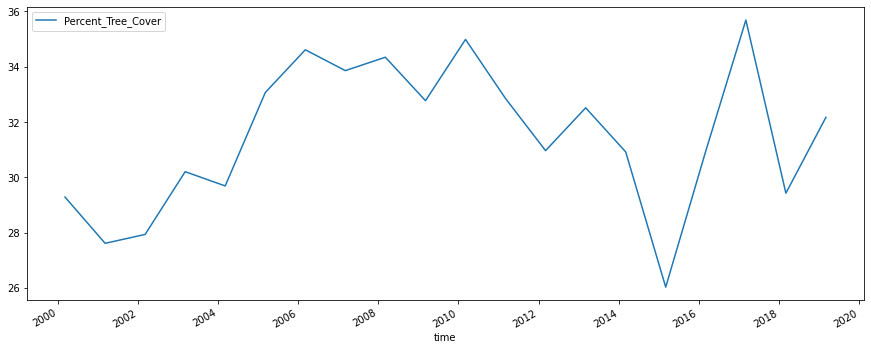

In [9]:
# Plotting

rcParams['figure.figsize'] = 15, 6
group.plot()
plt.show()


In [16]:
df

,Percent_Tree_Cover,Percent_NonTree_Vegetation,Percent_NonVegetated,time
0,NaN,NaN,NaN,2000-03-05
1,NaN,NaN,NaN,2001-03-06
2,NaN,NaN,NaN,2002-03-06
3,NaN,NaN,NaN,2003-03-06
4,NaN,NaN,NaN,2004-03-05
...,...,...,...,...
10075,NaN,NaN,NaN,2015-03-06
10076,NaN,NaN,NaN,2016-03-05
10077,NaN,NaN,NaN,2017-03-06
10078,NaN,NaN,NaN,2018-03-06


In [13]:
from pprint import pprint

pprint(info)

[['id',
  'longitude',
  'latitude',
  'time',
  'Percent_Tree_Cover',
  'Percent_NonTree_Vegetation',
  'Percent_NonVegetated'],
 ['2000_03_05',
  -74.47033705350833,
  17.696811097154573,
  952214400000,
  None,
  None,
  None],
 ['2001_03_06',
  -74.47033705350833,
  17.696811097154573,
  983836800000,
  None,
  None,
  None],
 ['2002_03_06',
  -74.47033705350833,
  17.696811097154573,
  1015372800000,
  None,
  None,
  None],
 ['2003_03_06',
  -74.47033705350833,
  17.696811097154573,
  1046908800000,
  None,
  None,
  None],
 ['2004_03_05',
  -74.47033705350833,
  17.696811097154573,
  1078444800000,
  None,
  None,
  None],
 ['2005_03_06',
  -74.47033705350833,
  17.696811097154573,
  1110067200000,
  None,
  None,
  None],
 ['2006_03_06',
  -74.47033705350833,
  17.696811097154573,
  1141603200000,
  None,
  None,
  None],
 ['2007_03_06',
  -74.47033705350833,
  17.696811097154573,
  1173139200000,
  None,
  None,
  None],
 ['2008_03_05',
  -74.47033705350833,
  17.6968110971545

 ['2013_03_06',
  -72.13471731479757,
  17.696811097154573,
  1362528000000,
  None,
  None,
  None],
 ['2014_03_06',
  -72.13471731479757,
  17.696811097154573,
  1394064000000,
  None,
  None,
  None],
 ['2015_03_06',
  -72.13471731479757,
  17.696811097154573,
  1425600000000,
  None,
  None,
  None],
 ['2016_03_05',
  -72.13471731479757,
  17.696811097154573,
  1457136000000,
  None,
  None,
  None],
 ['2017_03_06',
  -72.13471731479757,
  17.696811097154573,
  1488758400000,
  None,
  None,
  None],
 ['2018_03_06',
  -72.13471731479757,
  17.696811097154573,
  1520294400000,
  None,
  None,
  None],
 ['2019_03_06',
  -72.13471731479757,
  17.696811097154573,
  1551830400000,
  None,
  None,
  None],
 ['2000_03_05',
  -71.95505425797367,
  17.696811097154573,
  952214400000,
  None,
  None,
  None],
 ['2001_03_06',
  -71.95505425797367,
  17.696811097154573,
  983836800000,
  None,
  None,
  None],
 ['2002_03_06',
  -71.95505425797367,
  17.696811097154573,
  1015372800000,
  None,

  1046908800000,
  None,
  None,
  None],
 ['2004_03_05',
  -69.43977146243901,
  17.696811097154573,
  1078444800000,
  None,
  None,
  None],
 ['2005_03_06',
  -69.43977146243901,
  17.696811097154573,
  1110067200000,
  None,
  None,
  None],
 ['2006_03_06',
  -69.43977146243901,
  17.696811097154573,
  1141603200000,
  None,
  None,
  None],
 ['2007_03_06',
  -69.43977146243901,
  17.696811097154573,
  1173139200000,
  None,
  None,
  None],
 ['2008_03_05',
  -69.43977146243901,
  17.696811097154573,
  1204675200000,
  None,
  None,
  None],
 ['2009_03_06',
  -69.43977146243901,
  17.696811097154573,
  1236297600000,
  None,
  None,
  None],
 ['2010_03_06',
  -69.43977146243901,
  17.696811097154573,
  1267833600000,
  None,
  None,
  None],
 ['2011_03_06',
  -69.43977146243901,
  17.696811097154573,
  1299369600000,
  None,
  None,
  None],
 ['2012_03_05',
  -69.43977146243901,
  17.696811097154573,
  1330905600000,
  None,
  None,
  None],
 ['2013_03_06',
  -69.43977146243901,
  

 ['2000_03_05',
  -73.212695655741,
  17.876474153978478,
  952214400000,
  None,
  None,
  None],
 ['2001_03_06',
  -73.212695655741,
  17.876474153978478,
  983836800000,
  None,
  None,
  None],
 ['2002_03_06',
  -73.212695655741,
  17.876474153978478,
  1015372800000,
  None,
  None,
  None],
 ['2003_03_06',
  -73.212695655741,
  17.876474153978478,
  1046908800000,
  None,
  None,
  None],
 ['2004_03_05',
  -73.212695655741,
  17.876474153978478,
  1078444800000,
  None,
  None,
  None],
 ['2005_03_06',
  -73.212695655741,
  17.876474153978478,
  1110067200000,
  None,
  None,
  None],
 ['2006_03_06',
  -73.212695655741,
  17.876474153978478,
  1141603200000,
  None,
  None,
  None],
 ['2007_03_06',
  -73.212695655741,
  17.876474153978478,
  1173139200000,
  None,
  None,
  None],
 ['2008_03_05',
  -73.212695655741,
  17.876474153978478,
  1204675200000,
  None,
  None,
  None],
 ['2009_03_06',
  -73.212695655741,
  17.876474153978478,
  1236297600000,
  None,
  None,
  None],
 [

 ['2001_03_06',
  -70.51774980338243,
  17.876474153978478,
  983836800000,
  None,
  None,
  None],
 ['2002_03_06',
  -70.51774980338243,
  17.876474153978478,
  1015372800000,
  None,
  None,
  None],
 ['2003_03_06',
  -70.51774980338243,
  17.876474153978478,
  1046908800000,
  None,
  None,
  None],
 ['2004_03_05',
  -70.51774980338243,
  17.876474153978478,
  1078444800000,
  None,
  None,
  None],
 ['2005_03_06',
  -70.51774980338243,
  17.876474153978478,
  1110067200000,
  None,
  None,
  None],
 ['2006_03_06',
  -70.51774980338243,
  17.876474153978478,
  1141603200000,
  None,
  None,
  None],
 ['2007_03_06',
  -70.51774980338243,
  17.876474153978478,
  1173139200000,
  None,
  None,
  None],
 ['2008_03_05',
  -70.51774980338243,
  17.876474153978478,
  1204675200000,
  None,
  None,
  None],
 ['2009_03_06',
  -70.51774980338243,
  17.876474153978478,
  1236297600000,
  None,
  None,
  None],
 ['2010_03_06',
  -70.51774980338243,
  17.876474153978478,
  1267833600000,
  None

 ['2007_03_06',
  -74.47033705350833,
  18.056137210802383,
  1173139200000,
  None,
  None,
  None],
 ['2008_03_05',
  -74.47033705350833,
  18.056137210802383,
  1204675200000,
  None,
  None,
  None],
 ['2009_03_06',
  -74.47033705350833,
  18.056137210802383,
  1236297600000,
  None,
  None,
  None],
 ['2010_03_06',
  -74.47033705350833,
  18.056137210802383,
  1267833600000,
  None,
  None,
  None],
 ['2011_03_06',
  -74.47033705350833,
  18.056137210802383,
  1299369600000,
  None,
  None,
  None],
 ['2012_03_05',
  -74.47033705350833,
  18.056137210802383,
  1330905600000,
  None,
  None,
  None],
 ['2013_03_06',
  -74.47033705350833,
  18.056137210802383,
  1362528000000,
  None,
  None,
  None],
 ['2014_03_06',
  -74.47033705350833,
  18.056137210802383,
  1394064000000,
  None,
  None,
  None],
 ['2015_03_06',
  -74.47033705350833,
  18.056137210802383,
  1425600000000,
  None,
  None,
  None],
 ['2016_03_05',
  -74.47033705350833,
  18.056137210802383,
  1457136000000,
  Non

 ['2010_03_06',
  -71.77539120114976,
  18.056137210802383,
  1267833600000,
  33,
  54,
  14],
 ['2011_03_06',
  -71.77539120114976,
  18.056137210802383,
  1299369600000,
  26,
  60,
  15],
 ['2012_03_05',
  -71.77539120114976,
  18.056137210802383,
  1330905600000,
  20,
  57,
  24],
 ['2013_03_06',
  -71.77539120114976,
  18.056137210802383,
  1362528000000,
  17,
  64,
  21],
 ['2014_03_06',
  -71.77539120114976,
  18.056137210802383,
  1394064000000,
  14,
  64,
  24],
 ['2015_03_06',
  -71.77539120114976,
  18.056137210802383,
  1425600000000,
  11,
  65,
  26],
 ['2016_03_05',
  -71.77539120114976,
  18.056137210802383,
  1457136000000,
  18,
  59,
  25],
 ['2017_03_06',
  -71.77539120114976,
  18.056137210802383,
  1488758400000,
  25,
  58,
  20],
 ['2018_03_06',
  -71.77539120114976,
  18.056137210802383,
  1520294400000,
  13,
  69,
  20],
 ['2019_03_06',
  -71.77539120114976,
  18.056137210802383,
  1551830400000,
  19,
  66,
  17],
 ['2000_03_05',
  -71.59572814432586,
  

  18.056137210802383,
  1362528000000,
  None,
  None,
  None],
 ['2014_03_06',
  -69.2601084056151,
  18.056137210802383,
  1394064000000,
  None,
  None,
  None],
 ['2015_03_06',
  -69.2601084056151,
  18.056137210802383,
  1425600000000,
  None,
  None,
  None],
 ['2016_03_05',
  -69.2601084056151,
  18.056137210802383,
  1457136000000,
  None,
  None,
  None],
 ['2017_03_06',
  -69.2601084056151,
  18.056137210802383,
  1488758400000,
  None,
  None,
  None],
 ['2018_03_06',
  -69.2601084056151,
  18.056137210802383,
  1520294400000,
  None,
  None,
  None],
 ['2019_03_06',
  -69.2601084056151,
  18.056137210802383,
  1551830400000,
  None,
  None,
  None],
 ['2000_03_05',
  -69.0804453487912,
  18.056137210802383,
  952214400000,
  None,
  None,
  None],
 ['2001_03_06',
  -69.0804453487912,
  18.056137210802383,
  983836800000,
  None,
  None,
  None],
 ['2002_03_06',
  -69.0804453487912,
  18.056137210802383,
  1015372800000,
  None,
  None,
  None],
 ['2003_03_06',
  -69.0804453

 ['2000_03_05',
  -73.57202176938881,
  18.235800267626285,
  952214400000,
  15,
  61,
  23],
 ['2001_03_06',
  -73.57202176938881,
  18.235800267626285,
  983836800000,
  20,
  60,
  21],
 ['2002_03_06',
  -73.57202176938881,
  18.235800267626285,
  1015372800000,
  23,
  67,
  11],
 ['2003_03_06',
  -73.57202176938881,
  18.235800267626285,
  1046908800000,
  21,
  64,
  15],
 ['2004_03_05',
  -73.57202176938881,
  18.235800267626285,
  1078444800000,
  20,
  68,
  12],
 ['2005_03_06',
  -73.57202176938881,
  18.235800267626285,
  1110067200000,
  24,
  57,
  20],
 ['2006_03_06',
  -73.57202176938881,
  18.235800267626285,
  1141603200000,
  21,
  59,
  20],
 ['2007_03_06',
  -73.57202176938881,
  18.235800267626285,
  1173139200000,
  28,
  58,
  15],
 ['2008_03_05',
  -73.57202176938881,
  18.235800267626285,
  1204675200000,
  33,
  56,
  12],
 ['2009_03_06',
  -73.57202176938881,
  18.235800267626285,
  1236297600000,
  29,
  59,
  13],
 ['2010_03_06',
  -73.57202176938881,
  18

 ['2005_03_06',
  -71.05673897385415,
  18.235800267626285,
  1110067200000,
  43,
  50,
  9],
 ['2006_03_06',
  -71.05673897385415,
  18.235800267626285,
  1141603200000,
  46,
  37,
  17],
 ['2007_03_06',
  -71.05673897385415,
  18.235800267626285,
  1173139200000,
  43,
  43,
  15],
 ['2008_03_05',
  -71.05673897385415,
  18.235800267626285,
  1204675200000,
  43,
  44,
  15],
 ['2009_03_06',
  -71.05673897385415,
  18.235800267626285,
  1236297600000,
  42,
  44,
  16],
 ['2010_03_06',
  -71.05673897385415,
  18.235800267626285,
  1267833600000,
  42,
  40,
  20],
 ['2011_03_06',
  -71.05673897385415,
  18.235800267626285,
  1299369600000,
  45,
  48,
  9],
 ['2012_03_05',
  -71.05673897385415,
  18.235800267626285,
  1330905600000,
  43,
  42,
  16],
 ['2013_03_06',
  -71.05673897385415,
  18.235800267626285,
  1362528000000,
  39,
  46,
  17],
 ['2014_03_06',
  -71.05673897385415,
  18.235800267626285,
  1394064000000,
  40,
  49,
  13],
 ['2015_03_06',
  -71.05673897385415,
  18

  22,
  22],
 ['2016_03_05',
  -68.72111923514339,
  18.235800267626285,
  1457136000000,
  64,
  25,
  12],
 ['2017_03_06',
  -68.72111923514339,
  18.235800267626285,
  1488758400000,
  67,
  24,
  11],
 ['2018_03_06',
  -68.72111923514339,
  18.235800267626285,
  1520294400000,
  60,
  31,
  10],
 ['2019_03_06',
  -68.72111923514339,
  18.235800267626285,
  1551830400000,
  66,
  23,
  11],
 ['2000_03_05',
  -68.54145617831949,
  18.235800267626285,
  952214400000,
  59,
  37,
  6],
 ['2001_03_06',
  -68.54145617831949,
  18.235800267626285,
  983836800000,
  63,
  29,
  9],
 ['2002_03_06',
  -68.54145617831949,
  18.235800267626285,
  1015372800000,
  61,
  32,
  7],
 ['2003_03_06',
  -68.54145617831949,
  18.235800267626285,
  1046908800000,
  65,
  29,
  6],
 ['2004_03_05',
  -68.54145617831949,
  18.235800267626285,
  1078444800000,
  66,
  21,
  13],
 ['2005_03_06',
  -68.54145617831949,
  18.235800267626285,
  1110067200000,
  64,
  31,
  6],
 ['2006_03_06',
  -68.541456178319

  17],
 ['2005_03_06',
  -72.49404342844538,
  18.41546332445019,
  1110067200000,
  19,
  72,
  12],
 ['2006_03_06',
  -72.49404342844538,
  18.41546332445019,
  1141603200000,
  24,
  65,
  13],
 ['2007_03_06',
  -72.49404342844538,
  18.41546332445019,
  1173139200000,
  21,
  68,
  13],
 ['2008_03_05',
  -72.49404342844538,
  18.41546332445019,
  1204675200000,
  20,
  68,
  13],
 ['2009_03_06',
  -72.49404342844538,
  18.41546332445019,
  1236297600000,
  25,
  64,
  13],
 ['2010_03_06',
  -72.49404342844538,
  18.41546332445019,
  1267833600000,
  26,
  65,
  12],
 ['2011_03_06',
  -72.49404342844538,
  18.41546332445019,
  1299369600000,
  18,
  73,
  12],
 ['2012_03_05',
  -72.49404342844538,
  18.41546332445019,
  1330905600000,
  17,
  69,
  16],
 ['2013_03_06',
  -72.49404342844538,
  18.41546332445019,
  1362528000000,
  22,
  67,
  14],
 ['2014_03_06',
  -72.49404342844538,
  18.41546332445019,
  1394064000000,
  18,
  68,
  16],
 ['2015_03_06',
  -72.49404342844538,
  18.

  13],
 ['2002_03_06',
  -69.61943451926291,
  18.41546332445019,
  1015372800000,
  32,
  56,
  13],
 ['2003_03_06',
  -69.61943451926291,
  18.41546332445019,
  1046908800000,
  31,
  61,
  10],
 ['2004_03_05',
  -69.61943451926291,
  18.41546332445019,
  1078444800000,
  26,
  63,
  13],
 ['2005_03_06',
  -69.61943451926291,
  18.41546332445019,
  1110067200000,
  31,
  58,
  12],
 ['2006_03_06',
  -69.61943451926291,
  18.41546332445019,
  1141603200000,
  36,
  54,
  11],
 ['2007_03_06',
  -69.61943451926291,
  18.41546332445019,
  1173139200000,
  34,
  56,
  11],
 ['2008_03_05',
  -69.61943451926291,
  18.41546332445019,
  1204675200000,
  35,
  55,
  12],
 ['2009_03_06',
  -69.61943451926291,
  18.41546332445019,
  1236297600000,
  31,
  57,
  14],
 ['2010_03_06',
  -69.61943451926291,
  18.41546332445019,
  1267833600000,
  31,
  58,
  13],
 ['2011_03_06',
  -69.61943451926291,
  18.41546332445019,
  1299369600000,
  30,
  61,
  10],
 ['2012_03_05',
  -69.61943451926291,
  18.

 ['2014_03_06',
  -73.57202176938881,
  18.595126381274095,
  1394064000000,
  66,
  27,
  7],
 ['2015_03_06',
  -73.57202176938881,
  18.595126381274095,
  1425600000000,
  70,
  22,
  9],
 ['2016_03_05',
  -73.57202176938881,
  18.595126381274095,
  1457136000000,
  58,
  34,
  8],
 ['2017_03_06',
  -73.57202176938881,
  18.595126381274095,
  1488758400000,
  55,
  37,
  8],
 ['2018_03_06',
  -73.57202176938881,
  18.595126381274095,
  1520294400000,
  56,
  37,
  8],
 ['2019_03_06',
  -73.57202176938881,
  18.595126381274095,
  1551830400000,
  67,
  29,
  4],
 ['2000_03_05',
  -73.3923587125649,
  18.595126381274095,
  952214400000,
  None,
  None,
  None],
 ['2001_03_06',
  -73.3923587125649,
  18.595126381274095,
  983836800000,
  None,
  None,
  None],
 ['2002_03_06',
  -73.3923587125649,
  18.595126381274095,
  1015372800000,
  None,
  None,
  None],
 ['2003_03_06',
  -73.3923587125649,
  18.595126381274095,
  1046908800000,
  None,
  None,
  None],
 ['2004_03_05',
  -73.392358

  -70.87707591703024,
  18.595126381274095,
  1425600000000,
  32,
  56,
  14],
 ['2016_03_05',
  -70.87707591703024,
  18.595126381274095,
  1457136000000,
  39,
  43,
  20],
 ['2017_03_06',
  -70.87707591703024,
  18.595126381274095,
  1488758400000,
  44,
  47,
  11],
 ['2018_03_06',
  -70.87707591703024,
  18.595126381274095,
  1520294400000,
  36,
  58,
  9],
 ['2019_03_06',
  -70.87707591703024,
  18.595126381274095,
  1551830400000,
  40,
  50,
  13],
 ['2000_03_05',
  -70.69741286020634,
  18.595126381274095,
  952214400000,
  29,
  61,
  13],
 ['2001_03_06',
  -70.69741286020634,
  18.595126381274095,
  983836800000,
  29,
  59,
  14],
 ['2002_03_06',
  -70.69741286020634,
  18.595126381274095,
  1015372800000,
  35,
  57,
  10],
 ['2003_03_06',
  -70.69741286020634,
  18.595126381274095,
  1046908800000,
  32,
  58,
  12],
 ['2004_03_05',
  -70.69741286020634,
  18.595126381274095,
  1078444800000,
  34,
  55,
  13],
 ['2005_03_06',
  -70.69741286020634,
  18.595126381274095,

 ['2002_03_06',
  -68.18213006467168,
  18.595126381274095,
  1015372800000,
  None,
  None,
  None],
 ['2003_03_06',
  -68.18213006467168,
  18.595126381274095,
  1046908800000,
  None,
  None,
  None],
 ['2004_03_05',
  -68.18213006467168,
  18.595126381274095,
  1078444800000,
  None,
  None,
  None],
 ['2005_03_06',
  -68.18213006467168,
  18.595126381274095,
  1110067200000,
  None,
  None,
  None],
 ['2006_03_06',
  -68.18213006467168,
  18.595126381274095,
  1141603200000,
  None,
  None,
  None],
 ['2007_03_06',
  -68.18213006467168,
  18.595126381274095,
  1173139200000,
  None,
  None,
  None],
 ['2008_03_05',
  -68.18213006467168,
  18.595126381274095,
  1204675200000,
  None,
  None,
  None],
 ['2009_03_06',
  -68.18213006467168,
  18.595126381274095,
  1236297600000,
  None,
  None,
  None],
 ['2010_03_06',
  -68.18213006467168,
  18.595126381274095,
  1267833600000,
  None,
  None,
  None],
 ['2011_03_06',
  -68.18213006467168,
  18.595126381274095,
  1299369600000,
  Non

  -72.31438037162148,
  18.774789438097997,
  1362528000000,
  6,
  74,
  22],
 ['2014_03_06',
  -72.31438037162148,
  18.774789438097997,
  1394064000000,
  5,
  70,
  27],
 ['2015_03_06',
  -72.31438037162148,
  18.774789438097997,
  1425600000000,
  4,
  67,
  31],
 ['2016_03_05',
  -72.31438037162148,
  18.774789438097997,
  1457136000000,
  8,
  69,
  25],
 ['2017_03_06',
  -72.31438037162148,
  18.774789438097997,
  1488758400000,
  9,
  71,
  22],
 ['2018_03_06',
  -72.31438037162148,
  18.774789438097997,
  1520294400000,
  6,
  69,
  27],
 ['2019_03_06',
  -72.31438037162148,
  18.774789438097997,
  1551830400000,
  9,
  73,
  20],
 ['2000_03_05',
  -72.13471731479757,
  18.774789438097997,
  952214400000,
  13,
  72,
  18],
 ['2001_03_06',
  -72.13471731479757,
  18.774789438097997,
  983836800000,
  12,
  70,
  21],
 ['2002_03_06',
  -72.13471731479757,
  18.774789438097997,
  1015372800000,
  11,
  75,
  16],
 ['2003_03_06',
  -72.13471731479757,
  18.774789438097997,
  104

 ['2004_03_05',
  -69.61943451926291,
  18.774789438097997,
  1078444800000,
  29,
  64,
  9],
 ['2005_03_06',
  -69.61943451926291,
  18.774789438097997,
  1110067200000,
  35,
  60,
  8],
 ['2006_03_06',
  -69.61943451926291,
  18.774789438097997,
  1141603200000,
  41,
  56,
  6],
 ['2007_03_06',
  -69.61943451926291,
  18.774789438097997,
  1173139200000,
  34,
  57,
  11],
 ['2008_03_05',
  -69.61943451926291,
  18.774789438097997,
  1204675200000,
  40,
  52,
  10],
 ['2009_03_06',
  -69.61943451926291,
  18.774789438097997,
  1236297600000,
  40,
  51,
  11],
 ['2010_03_06',
  -69.61943451926291,
  18.774789438097997,
  1267833600000,
  39,
  52,
  11],
 ['2011_03_06',
  -69.61943451926291,
  18.774789438097997,
  1299369600000,
  37,
  59,
  6],
 ['2012_03_05',
  -69.61943451926291,
  18.774789438097997,
  1330905600000,
  36,
  57,
  9],
 ['2013_03_06',
  -69.61943451926291,
  18.774789438097997,
  1362528000000,
  37,
  57,
  7],
 ['2014_03_06',
  -69.61943451926291,
  18.774

  18.954452494921902,
  983836800000,
  20,
  67,
  14],
 ['2002_03_06',
  -72.85336954209319,
  18.954452494921902,
  1015372800000,
  16,
  70,
  16],
 ['2003_03_06',
  -72.85336954209319,
  18.954452494921902,
  1046908800000,
  23,
  67,
  11],
 ['2004_03_05',
  -72.85336954209319,
  18.954452494921902,
  1078444800000,
  15,
  71,
  14],
 ['2005_03_06',
  -72.85336954209319,
  18.954452494921902,
  1110067200000,
  22,
  65,
  13],
 ['2006_03_06',
  -72.85336954209319,
  18.954452494921902,
  1141603200000,
  20,
  64,
  17],
 ['2007_03_06',
  -72.85336954209319,
  18.954452494921902,
  1173139200000,
  19,
  65,
  17],
 ['2008_03_05',
  -72.85336954209319,
  18.954452494921902,
  1204675200000,
  27,
  64,
  10],
 ['2009_03_06',
  -72.85336954209319,
  18.954452494921902,
  1236297600000,
  29,
  60,
  12],
 ['2010_03_06',
  -72.85336954209319,
  18.954452494921902,
  1267833600000,
  30,
  61,
  11],
 ['2011_03_06',
  -72.85336954209319,
  18.954452494921902,
  1299369600000,
  

  -70.33808674655853,
  18.954452494921902,
  1267833600000,
  50,
  41,
  10],
 ['2011_03_06',
  -70.33808674655853,
  18.954452494921902,
  1299369600000,
  55,
  41,
  5],
 ['2012_03_05',
  -70.33808674655853,
  18.954452494921902,
  1330905600000,
  51,
  36,
  14],
 ['2013_03_06',
  -70.33808674655853,
  18.954452494921902,
  1362528000000,
  53,
  45,
  4],
 ['2014_03_06',
  -70.33808674655853,
  18.954452494921902,
  1394064000000,
  51,
  44,
  6],
 ['2015_03_06',
  -70.33808674655853,
  18.954452494921902,
  1425600000000,
  50,
  30,
  22],
 ['2016_03_05',
  -70.33808674655853,
  18.954452494921902,
  1457136000000,
  55,
  32,
  14],
 ['2017_03_06',
  -70.33808674655853,
  18.954452494921902,
  1488758400000,
  58,
  31,
  12],
 ['2018_03_06',
  -70.33808674655853,
  18.954452494921902,
  1520294400000,
  49,
  44,
  9],
 ['2019_03_06',
  -70.33808674655853,
  18.954452494921902,
  1551830400000,
  51,
  27,
  24],
 ['2000_03_05',
  -70.15842368973463,
  18.954452494921902,


  None],
 ['2014_03_06',
  -74.11101093986052,
  19.134115551745808,
  1394064000000,
  None,
  None,
  None],
 ['2015_03_06',
  -74.11101093986052,
  19.134115551745808,
  1425600000000,
  None,
  None,
  None],
 ['2016_03_05',
  -74.11101093986052,
  19.134115551745808,
  1457136000000,
  None,
  None,
  None],
 ['2017_03_06',
  -74.11101093986052,
  19.134115551745808,
  1488758400000,
  None,
  None,
  None],
 ['2018_03_06',
  -74.11101093986052,
  19.134115551745808,
  1520294400000,
  None,
  None,
  None],
 ['2019_03_06',
  -74.11101093986052,
  19.134115551745808,
  1551830400000,
  None,
  None,
  None],
 ['2000_03_05',
  -73.93134788303662,
  19.134115551745808,
  952214400000,
  None,
  None,
  None],
 ['2001_03_06',
  -73.93134788303662,
  19.134115551745808,
  983836800000,
  None,
  None,
  None],
 ['2002_03_06',
  -73.93134788303662,
  19.134115551745808,
  1015372800000,
  None,
  None,
  None],
 ['2003_03_06',
  -73.93134788303662,
  19.134115551745808,
  1046908800000

  75,
  20],
 ['2004_03_05',
  -71.77539120114976,
  19.134115551745808,
  1078444800000,
  6,
  77,
  20],
 ['2005_03_06',
  -71.77539120114976,
  19.134115551745808,
  1110067200000,
  7,
  73,
  22],
 ['2006_03_06',
  -71.77539120114976,
  19.134115551745808,
  1141603200000,
  10,
  72,
  20],
 ['2007_03_06',
  -71.77539120114976,
  19.134115551745808,
  1173139200000,
  12,
  72,
  18],
 ['2008_03_05',
  -71.77539120114976,
  19.134115551745808,
  1204675200000,
  10,
  76,
  16],
 ['2009_03_06',
  -71.77539120114976,
  19.134115551745808,
  1236297600000,
  9,
  72,
  20],
 ['2010_03_06',
  -71.77539120114976,
  19.134115551745808,
  1267833600000,
  10,
  75,
  17],
 ['2011_03_06',
  -71.77539120114976,
  19.134115551745808,
  1299369600000,
  6,
  73,
  23],
 ['2012_03_05',
  -71.77539120114976,
  19.134115551745808,
  1330905600000,
  7,
  74,
  21],
 ['2013_03_06',
  -71.77539120114976,
  19.134115551745808,
  1362528000000,
  10,
  76,
  17],
 ['2014_03_06',
  -71.7753912011

  19.134115551745808,
  952214400000,
  None,
  None,
  None],
 ['2001_03_06',
  -69.0804453487912,
  19.134115551745808,
  983836800000,
  None,
  None,
  None],
 ['2002_03_06',
  -69.0804453487912,
  19.134115551745808,
  1015372800000,
  None,
  None,
  None],
 ['2003_03_06',
  -69.0804453487912,
  19.134115551745808,
  1046908800000,
  None,
  None,
  None],
 ['2004_03_05',
  -69.0804453487912,
  19.134115551745808,
  1078444800000,
  None,
  None,
  None],
 ['2005_03_06',
  -69.0804453487912,
  19.134115551745808,
  1110067200000,
  None,
  None,
  None],
 ['2006_03_06',
  -69.0804453487912,
  19.134115551745808,
  1141603200000,
  None,
  None,
  None],
 ['2007_03_06',
  -69.0804453487912,
  19.134115551745808,
  1173139200000,
  None,
  None,
  None],
 ['2008_03_05',
  -69.0804453487912,
  19.134115551745808,
  1204675200000,
  None,
  None,
  None],
 ['2009_03_06',
  -69.0804453487912,
  19.134115551745808,
  1236297600000,
  None,
  None,
  None],
 ['2010_03_06',
  -69.0804453

  983836800000,
  9,
  55,
  36],
 ['2002_03_06',
  -72.85336954209319,
  19.313778608569713,
  1015372800000,
  12,
  53,
  35],
 ['2003_03_06',
  -72.85336954209319,
  19.313778608569713,
  1046908800000,
  12,
  56,
  33],
 ['2004_03_05',
  -72.85336954209319,
  19.313778608569713,
  1078444800000,
  14,
  54,
  33],
 ['2005_03_06',
  -72.85336954209319,
  19.313778608569713,
  1110067200000,
  10,
  58,
  34],
 ['2006_03_06',
  -72.85336954209319,
  19.313778608569713,
  1141603200000,
  13,
  52,
  35],
 ['2007_03_06',
  -72.85336954209319,
  19.313778608569713,
  1173139200000,
  13,
  54,
  33],
 ['2008_03_05',
  -72.85336954209319,
  19.313778608569713,
  1204675200000,
  13,
  51,
  36],
 ['2009_03_06',
  -72.85336954209319,
  19.313778608569713,
  1236297600000,
  13,
  55,
  32],
 ['2010_03_06',
  -72.85336954209319,
  19.313778608569713,
  1267833600000,
  14,
  54,
  32],
 ['2011_03_06',
  -72.85336954209319,
  19.313778608569713,
  1299369600000,
  15,
  54,
  32],
 ['201

  1173139200000,
  27,
  54,
  21],
 ['2008_03_05',
  -70.33808674655853,
  19.313778608569713,
  1204675200000,
  36,
  47,
  19],
 ['2009_03_06',
  -70.33808674655853,
  19.313778608569713,
  1236297600000,
  23,
  66,
  13],
 ['2010_03_06',
  -70.33808674655853,
  19.313778608569713,
  1267833600000,
  30,
  59,
  13],
 ['2011_03_06',
  -70.33808674655853,
  19.313778608569713,
  1299369600000,
  30,
  60,
  12],
 ['2012_03_05',
  -70.33808674655853,
  19.313778608569713,
  1330905600000,
  24,
  52,
  25],
 ['2013_03_06',
  -70.33808674655853,
  19.313778608569713,
  1362528000000,
  31,
  62,
  10],
 ['2014_03_06',
  -70.33808674655853,
  19.313778608569713,
  1394064000000,
  27,
  61,
  14],
 ['2015_03_06',
  -70.33808674655853,
  19.313778608569713,
  1425600000000,
  20,
  56,
  26],
 ['2016_03_05',
  -70.33808674655853,
  19.313778608569713,
  1457136000000,
  31,
  51,
  20],
 ['2017_03_06',
  -70.33808674655853,
  19.313778608569713,
  1488758400000,
  30,
  60,
  12],
 ['2

 ['2015_03_06',
  -68.36179312149558,
  19.313778608569713,
  1425600000000,
  None,
  None,
  None],
 ['2016_03_05',
  -68.36179312149558,
  19.313778608569713,
  1457136000000,
  None,
  None,
  None],
 ['2017_03_06',
  -68.36179312149558,
  19.313778608569713,
  1488758400000,
  None,
  None,
  None],
 ['2018_03_06',
  -68.36179312149558,
  19.313778608569713,
  1520294400000,
  None,
  None,
  None],
 ['2019_03_06',
  -68.36179312149558,
  19.313778608569713,
  1551830400000,
  None,
  None,
  None],
 ['2000_03_05',
  -68.18213006467168,
  19.313778608569713,
  952214400000,
  None,
  None,
  None],
 ['2001_03_06',
  -68.18213006467168,
  19.313778608569713,
  983836800000,
  None,
  None,
  None],
 ['2002_03_06',
  -68.18213006467168,
  19.313778608569713,
  1015372800000,
  None,
  None,
  None],
 ['2003_03_06',
  -68.18213006467168,
  19.313778608569713,
  1046908800000,
  None,
  None,
  None],
 ['2004_03_05',
  -68.18213006467168,
  19.313778608569713,
  1078444800000,
  None,

 ['2006_03_06',
  -72.31438037162148,
  19.493441665393615,
  1141603200000,
  34,
  58,
  11],
 ['2007_03_06',
  -72.31438037162148,
  19.493441665393615,
  1173139200000,
  32,
  61,
  9],
 ['2008_03_05',
  -72.31438037162148,
  19.493441665393615,
  1204675200000,
  26,
  65,
  11],
 ['2009_03_06',
  -72.31438037162148,
  19.493441665393615,
  1236297600000,
  26,
  59,
  18],
 ['2010_03_06',
  -72.31438037162148,
  19.493441665393615,
  1267833600000,
  31,
  58,
  13],
 ['2011_03_06',
  -72.31438037162148,
  19.493441665393615,
  1299369600000,
  30,
  61,
  11],
 ['2012_03_05',
  -72.31438037162148,
  19.493441665393615,
  1330905600000,
  25,
  62,
  16],
 ['2013_03_06',
  -72.31438037162148,
  19.493441665393615,
  1362528000000,
  30,
  58,
  14],
 ['2014_03_06',
  -72.31438037162148,
  19.493441665393615,
  1394064000000,
  30,
  57,
  16],
 ['2015_03_06',
  -72.31438037162148,
  19.493441665393615,
  1425600000000,
  24,
  59,
  19],
 ['2016_03_05',
  -72.31438037162148,
  1

  None],
 ['2000_03_05',
  -69.2601084056151,
  19.493441665393615,
  952214400000,
  None,
  None,
  None],
 ['2001_03_06',
  -69.2601084056151,
  19.493441665393615,
  983836800000,
  None,
  None,
  None],
 ['2002_03_06',
  -69.2601084056151,
  19.493441665393615,
  1015372800000,
  None,
  None,
  None],
 ['2003_03_06',
  -69.2601084056151,
  19.493441665393615,
  1046908800000,
  None,
  None,
  None],
 ['2004_03_05',
  -69.2601084056151,
  19.493441665393615,
  1078444800000,
  None,
  None,
  None],
 ['2005_03_06',
  -69.2601084056151,
  19.493441665393615,
  1110067200000,
  None,
  None,
  None],
 ['2006_03_06',
  -69.2601084056151,
  19.493441665393615,
  1141603200000,
  None,
  None,
  None],
 ['2007_03_06',
  -69.2601084056151,
  19.493441665393615,
  1173139200000,
  None,
  None,
  None],
 ['2008_03_05',
  -69.2601084056151,
  19.493441665393615,
  1204675200000,
  None,
  None,
  None],
 ['2009_03_06',
  -69.2601084056151,
  19.493441665393615,
  1236297600000,
  None,


 ['2014_03_06',
  -73.3923587125649,
  19.67310472221752,
  1394064000000,
  16,
  67,
  18],
 ['2015_03_06', -73.3923587125649, 19.67310472221752, 1425600000000, 9, 67, 26],
 ['2016_03_05',
  -73.3923587125649,
  19.67310472221752,
  1457136000000,
  13,
  64,
  24],
 ['2017_03_06',
  -73.3923587125649,
  19.67310472221752,
  1488758400000,
  22,
  56,
  24],
 ['2018_03_06',
  -73.3923587125649,
  19.67310472221752,
  1520294400000,
  17,
  66,
  19],
 ['2019_03_06',
  -73.3923587125649,
  19.67310472221752,
  1551830400000,
  22,
  63,
  16],
 ['2000_03_05', -73.212695655741, 19.67310472221752, 952214400000, 16, 65, 21],
 ['2001_03_06', -73.212695655741, 19.67310472221752, 983836800000, 17, 64, 21],
 ['2002_03_06', -73.212695655741, 19.67310472221752, 1015372800000, 15, 65, 21],
 ['2003_03_06', -73.212695655741, 19.67310472221752, 1046908800000, 18, 62, 22],
 ['2004_03_05', -73.212695655741, 19.67310472221752, 1078444800000, 15, 68, 19],
 ['2005_03_06', -73.212695655741, 19.673104722

  -70.51774980338243,
  19.67310472221752,
  1362528000000,
  42,
  54,
  6],
 ['2014_03_06',
  -70.51774980338243,
  19.67310472221752,
  1394064000000,
  35,
  48,
  20],
 ['2015_03_06',
  -70.51774980338243,
  19.67310472221752,
  1425600000000,
  32,
  39,
  31],
 ['2016_03_05',
  -70.51774980338243,
  19.67310472221752,
  1457136000000,
  42,
  39,
  21],
 ['2017_03_06',
  -70.51774980338243,
  19.67310472221752,
  1488758400000,
  42,
  40,
  20],
 ['2018_03_06',
  -70.51774980338243,
  19.67310472221752,
  1520294400000,
  35,
  41,
  26],
 ['2019_03_06',
  -70.51774980338243,
  19.67310472221752,
  1551830400000,
  32,
  37,
  33],
 ['2000_03_05', -70.33808674655853, 19.67310472221752, 952214400000, 44, 50, 8],
 ['2001_03_06',
  -70.33808674655853,
  19.67310472221752,
  983836800000,
  39,
  48,
  14],
 ['2002_03_06',
  -70.33808674655853,
  19.67310472221752,
  1015372800000,
  43,
  48,
  10],
 ['2003_03_06',
  -70.33808674655853,
  19.67310472221752,
  1046908800000,
  51,


  None,
  None],
 ['2011_03_06',
  -74.29067399668442,
  19.852767779041425,
  1299369600000,
  None,
  None,
  None],
 ['2012_03_05',
  -74.29067399668442,
  19.852767779041425,
  1330905600000,
  None,
  None,
  None],
 ['2013_03_06',
  -74.29067399668442,
  19.852767779041425,
  1362528000000,
  None,
  None,
  None],
 ['2014_03_06',
  -74.29067399668442,
  19.852767779041425,
  1394064000000,
  None,
  None,
  None],
 ['2015_03_06',
  -74.29067399668442,
  19.852767779041425,
  1425600000000,
  None,
  None,
  None],
 ['2016_03_05',
  -74.29067399668442,
  19.852767779041425,
  1457136000000,
  None,
  None,
  None],
 ['2017_03_06',
  -74.29067399668442,
  19.852767779041425,
  1488758400000,
  None,
  None,
  None],
 ['2018_03_06',
  -74.29067399668442,
  19.852767779041425,
  1520294400000,
  None,
  None,
  None],
 ['2019_03_06',
  -74.29067399668442,
  19.852767779041425,
  1551830400000,
  None,
  None,
  None],
 ['2000_03_05',
  -74.11101093986052,
  19.852767779041425,
  952

  None],
 ['2019_03_06',
  -71.95505425797367,
  19.852767779041425,
  1551830400000,
  None,
  None,
  None],
 ['2000_03_05',
  -71.77539120114976,
  19.852767779041425,
  952214400000,
  18,
  52,
  32],
 ['2001_03_06',
  -71.77539120114976,
  19.852767779041425,
  983836800000,
  20,
  51,
  29],
 ['2002_03_06',
  -71.77539120114976,
  19.852767779041425,
  1015372800000,
  24,
  46,
  30],
 ['2003_03_06',
  -71.77539120114976,
  19.852767779041425,
  1046908800000,
  20,
  53,
  29],
 ['2004_03_05',
  -71.77539120114976,
  19.852767779041425,
  1078444800000,
  24,
  49,
  28],
 ['2005_03_06',
  -71.77539120114976,
  19.852767779041425,
  1110067200000,
  25,
  49,
  27],
 ['2006_03_06',
  -71.77539120114976,
  19.852767779041425,
  1141603200000,
  24,
  48,
  29],
 ['2007_03_06',
  -71.77539120114976,
  19.852767779041425,
  1173139200000,
  23,
  51,
  27],
 ['2008_03_05',
  -71.77539120114976,
  19.852767779041425,
  1204675200000,
  23,
  49,
  29],
 ['2009_03_06',
  -71.77539

  None,
  None,
  None],
 ['2016_03_05',
  -69.2601084056151,
  19.852767779041425,
  1457136000000,
  None,
  None,
  None],
 ['2017_03_06',
  -69.2601084056151,
  19.852767779041425,
  1488758400000,
  None,
  None,
  None],
 ['2018_03_06',
  -69.2601084056151,
  19.852767779041425,
  1520294400000,
  None,
  None,
  None],
 ['2019_03_06',
  -69.2601084056151,
  19.852767779041425,
  1551830400000,
  None,
  None,
  None],
 ['2000_03_05',
  -69.0804453487912,
  19.852767779041425,
  952214400000,
  None,
  None,
  None],
 ['2001_03_06',
  -69.0804453487912,
  19.852767779041425,
  983836800000,
  None,
  None,
  None],
 ['2002_03_06',
  -69.0804453487912,
  19.852767779041425,
  1015372800000,
  None,
  None,
  None],
 ['2003_03_06',
  -69.0804453487912,
  19.852767779041425,
  1046908800000,
  None,
  None,
  None],
 ['2004_03_05',
  -69.0804453487912,
  19.852767779041425,
  1078444800000,
  None,
  None,
  None],
 ['2005_03_06',
  -69.0804453487912,
  19.852767779041425,
  1110067

 ['2003_03_06',
  -73.3923587125649,
  20.03243083586533,
  1046908800000,
  None,
  None,
  None],
 ['2004_03_05',
  -73.3923587125649,
  20.03243083586533,
  1078444800000,
  None,
  None,
  None],
 ['2005_03_06',
  -73.3923587125649,
  20.03243083586533,
  1110067200000,
  None,
  None,
  None],
 ['2006_03_06',
  -73.3923587125649,
  20.03243083586533,
  1141603200000,
  None,
  None,
  None],
 ['2007_03_06',
  -73.3923587125649,
  20.03243083586533,
  1173139200000,
  None,
  None,
  None],
 ['2008_03_05',
  -73.3923587125649,
  20.03243083586533,
  1204675200000,
  None,
  None,
  None],
 ['2009_03_06',
  -73.3923587125649,
  20.03243083586533,
  1236297600000,
  None,
  None,
  None],
 ['2010_03_06',
  -73.3923587125649,
  20.03243083586533,
  1267833600000,
  None,
  None,
  None],
 ['2011_03_06',
  -73.3923587125649,
  20.03243083586533,
  1299369600000,
  None,
  None,
  None],
 ['2012_03_05',
  -73.3923587125649,
  20.03243083586533,
  1330905600000,
  None,
  None,
  None],


  20.03243083586533,
  1267833600000,
  None,
  None,
  None],
 ['2011_03_06',
  -70.87707591703024,
  20.03243083586533,
  1299369600000,
  None,
  None,
  None],
 ['2012_03_05',
  -70.87707591703024,
  20.03243083586533,
  1330905600000,
  None,
  None,
  None],
 ['2013_03_06',
  -70.87707591703024,
  20.03243083586533,
  1362528000000,
  None,
  None,
  None],
 ['2014_03_06',
  -70.87707591703024,
  20.03243083586533,
  1394064000000,
  None,
  None,
  None],
 ['2015_03_06',
  -70.87707591703024,
  20.03243083586533,
  1425600000000,
  None,
  None,
  None],
 ['2016_03_05',
  -70.87707591703024,
  20.03243083586533,
  1457136000000,
  None,
  None,
  None],
 ['2017_03_06',
  -70.87707591703024,
  20.03243083586533,
  1488758400000,
  None,
  None,
  None],
 ['2018_03_06',
  -70.87707591703024,
  20.03243083586533,
  1520294400000,
  None,
  None,
  None],
 ['2019_03_06',
  -70.87707591703024,
  20.03243083586533,
  1551830400000,
  None,
  None,
  None],
 ['2000_03_05',
  -70.697412

  None,
  None],
 ['2003_03_06',
  -68.36179312149558,
  20.03243083586533,
  1046908800000,
  None,
  None,
  None],
 ['2004_03_05',
  -68.36179312149558,
  20.03243083586533,
  1078444800000,
  None,
  None,
  None],
 ['2005_03_06',
  -68.36179312149558,
  20.03243083586533,
  1110067200000,
  None,
  None,
  None],
 ['2006_03_06',
  -68.36179312149558,
  20.03243083586533,
  1141603200000,
  None,
  None,
  None],
 ['2007_03_06',
  -68.36179312149558,
  20.03243083586533,
  1173139200000,
  None,
  None,
  None],
 ['2008_03_05',
  -68.36179312149558,
  20.03243083586533,
  1204675200000,
  None,
  None,
  None],
 ['2009_03_06',
  -68.36179312149558,
  20.03243083586533,
  1236297600000,
  None,
  None,
  None],
 ['2010_03_06',
  -68.36179312149558,
  20.03243083586533,
  1267833600000,
  None,
  None,
  None],
 ['2011_03_06',
  -68.36179312149558,
  20.03243083586533,
  1299369600000,
  None,
  None,
  None],
 ['2012_03_05',
  -68.36179312149558,
  20.03243083586533,
  1330905600000